In [4]:
import findspark
import psycopg2
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
db_credentials = {
    "user": "postgres",
    "password": "post",
    "host": "localhost",
    "port": "5432",
    "database": "postgres"
}

findspark.init()

spark = SparkSession.builder \
    .appName("PostgreSQL Connection with PySpark") \
    .getOrCreate()

query = "SELECT * FROM orders"
table_name = "orders"

# Connect to PostgreSQL and execute the query
connection = psycopg2.connect(**db_credentials)
cursor = connection.cursor()
cursor.execute(query)

# Fetch the query result into a list of tuples
result = cursor.fetchall()

# Extract column names from cursor.description
column_names = [desc[0] for desc in cursor.description]

# Create a DataFrame from the query result with proper schema
orders = spark.read.csv("C:/Users/DELL/Desktop/data/orders.csv", header=True)
order_items = spark.read.csv("C:/Users/DELL/Desktop/data/order_items.csv", header=True)
product = spark.read.csv("C:/Users/DELL/Desktop/data/products.csv", header=True)
customer = spark.read.csv("C:/Users/DELL/Desktop/data/customers.csv", header=True)

#join the order items with the order
order_details = orders.join(order_items.join(product , on = "product_id") , on = "order_id").join(customer , on = "customer_id")
order_details.createOrReplaceTempView("data")
result = spark.sql("SELECT product_id ,order_id , customer_id ,order_item_id from data")
result.show()
result = result.toPandas()
orders_pd = orders.toPandas()
order_items_pd = order_items.toPandas()
product_pd = product.toPandas()
customer_pd = customer.toPandas()
#convert the result to pandas data frame
def map_data_type(dtype):
    if dtype == 'int64' or dtype == 'int32':
        return 'bigint'
    elif dtype == 'float64':
        return 'decimal'
    elif dtype == 'object':
        return 'text'
    # Add more data type mappings as needed
    else:
        return 'text'
def convert_value(value):
    if isinstance(value, np.int64):
        return int(value)
    else:
        return value
column_names = list(result.columns)
datatypes = [map_data_type(result[col].dtype) for col in column_names]
orders_pdcolumn_names = list(orders_pd.columns)
orders_pddatatypes = [map_data_type(orders_pd[col].dtype) for col in orders_pdcolumn_names]
order_items_pdcolumn_names = list(order_items_pd.columns)
order_items_pddatatypes = [map_data_type(order_items_pd[col].dtype) for col in order_items_pdcolumn_names]
product_pdcolumn_names = list(product_pd.columns)
product_pddatatypes = [map_data_type(product_pd[col].dtype) for col in product_pdcolumn_names]
customer_pdcolumn_names = list(customer_pd.columns)
customer_pddatatypes = [map_data_type(customer_pd[col].dtype) for col in customer_pdcolumn_names]

create_table_query = f"""
        CREATE TABLE Fact_table (
            {", ".join([f"{col} {dtype}" for col, dtype in zip(column_names, datatypes)])}
        );
        """
create_table_orders = f"""
        CREATE TABLE orders (
            {", ".join([f"{col} {dtype}" for col, dtype in zip(orders_pdcolumn_names, orders_pddatatypes)])}
        );
        """
create_table_order_items = f"""
        CREATE TABLE order_items (
            {", ".join([f"{col} {dtype}" for col, dtype in zip(order_items_pdcolumn_names, order_items_pddatatypes)])}
        );
        """
create_table_product = f"""
        CREATE TABLE product (
            {", ".join([f"{col} {dtype}" for col, dtype in zip(product_pdcolumn_names, product_pddatatypes)])}
        );
        """
create_table_customer = f"""
        CREATE TABLE customer (
            {", ".join([f"{col} {dtype}" for col, dtype in zip(customer_pdcolumn_names, customer_pddatatypes)])}
        );
        """
db_credentials2 = {
    "user": "postgres",
    "password": "post",
    "host": "localhost",
    "port": "5432",
    "database": "test"
}
drop = "DROP TABLE IF EXISTS Fact_table" 
drop2 = "DROP TABLE IF EXISTS orders" 
drop3 = "DROP TABLE IF EXISTS order_items" 
drop4 = "DROP TABLE IF EXISTS product" 
drop5 = "DROP TABLE IF EXISTS customer" 
connection2 = psycopg2.connect(**db_credentials2)
cursor2 = connection2.cursor()
cursor2.execute(drop)
cursor2.execute(drop2)
cursor2.execute(drop3)
cursor2.execute(drop4)
cursor2.execute(drop5)
cursor2.execute(create_table_query)
cursor2.execute(create_table_orders)
cursor2.execute(create_table_order_items)
cursor2.execute(create_table_product)
cursor2.execute(create_table_customer)
connection2.commit()

data = [tuple(convert_value(value) for value in row) for row in result.to_records(index=False)]
data2 = [tuple(convert_value(value) for value in row) for row in orders_pd.to_records(index=False)]
data3 = [tuple(convert_value(value) for value in row) for row in order_items_pd.to_records(index=False)]
data4 = [tuple(convert_value(value) for value in row) for row in product_pd.to_records(index=False)]
data5 = [tuple(convert_value(value) for value in row) for row in customer_pd.to_records(index=False)]
        # Prepare the query for bulk insertion
insert_query = f"INSERT INTO Fact_table VALUES ({', '.join(['%s'] * len(column_names))})"
insert_query2 = f"INSERT INTO orders VALUES ({', '.join(['%s'] * len(orders_pdcolumn_names))})"
insert_query3 = f"INSERT INTO order_items VALUES ({', '.join(['%s'] * len(order_items_pdcolumn_names))})"
insert_query4 = f"INSERT INTO product VALUES ({', '.join(['%s'] * len(product_pdcolumn_names))})"
insert_query5 = f"INSERT INTO customer VALUES ({', '.join(['%s'] * len(customer_pdcolumn_names))})"
        # Execute the bulk insertion
cursor2.executemany(insert_query, data)
cursor2.executemany(insert_query2, data2)
cursor2.executemany(insert_query3, data3)
cursor2.executemany(insert_query4, data4)
cursor2.executemany(insert_query5, data5)
connection2.commit()
print("Data imported successfully!")


+----------+--------+-----------+-------------+
|product_id|order_id|customer_id|order_item_id|
+----------+--------+-----------+-------------+
|       957|       1|      11599|            1|
|      1073|       2|        256|            2|
|       502|       2|        256|            3|
|       403|       2|        256|            4|
|       897|       4|       8827|            5|
|       365|       4|       8827|            6|
|       502|       4|       8827|            7|
|      1014|       4|       8827|            8|
|       957|       5|      11318|            9|
|       365|       5|      11318|           10|
|      1014|       5|      11318|           11|
|       957|       5|      11318|           12|
|       403|       5|      11318|           13|
|      1073|       7|       4530|           14|
|       957|       7|       4530|           15|
|       926|       7|       4530|           16|
|       365|       8|       2911|           17|
|       365|       8|       2911|       

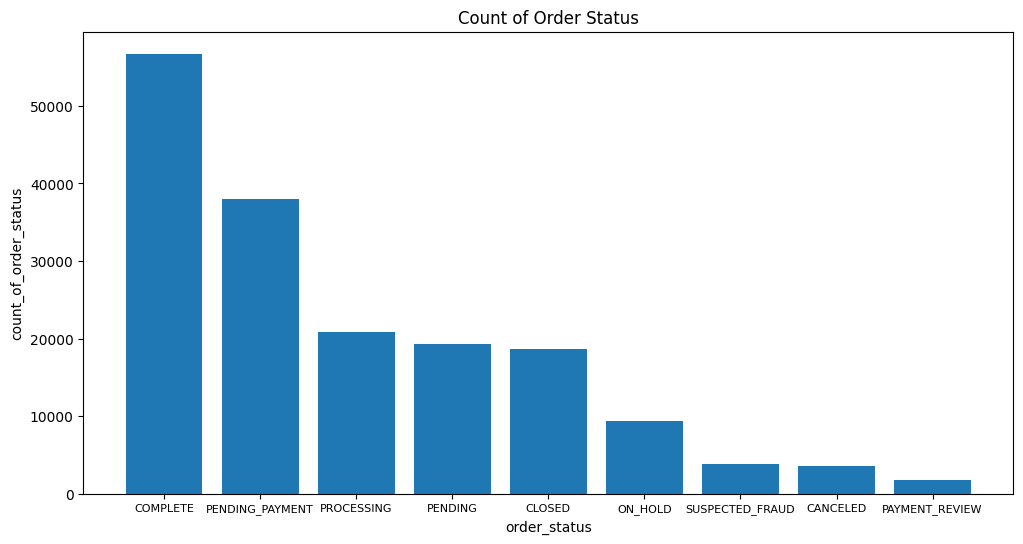

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

# Create a bar chart
sampled_data = result.select('order_status','count_of_order_status').sample(False, 0.8).toPandas()
plt.bar(sampled_data.order_status, sampled_data.count_of_order_status )

# Set x-axis label font size
plt.xticks(fontsize=8)

# Set labels and title
plt.xlabel('order_status')
plt.ylabel('count_of_order_status')
plt.title('Count of Order Status')

# Display the chart
plt.show()


In [6]:
import psycopg2



# Establish a connection to the database
db_credentials2 = {
    "user": "postgres",
    "password": "post",
    "host": "localhost",
    "port": "5432",
    "database": "test"
}
connection2 = psycopg2.connect(**db_credentials2)
cursor2 = connection2.cursor()

# Execute the ALTER TABLE statement
alert = "ALTER TABLE orderdetails RENAME TO order_status_report"
cursor2.execute(alert)
connection2.commit()

# Close the cursor and connection
cursor2.close()
connection2.close()

print("Alert Done")

Alert Done
